In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
# 制作数据集
class MyData(Dataset):                  # 继承Dataset类
    def __init__(self, filepath):
        df = pd.read_csv(filepath, index_col=0)    # 导入数据
        arr = df.values                 # 对象退化为数组
        arr = arr.astype(np.float32)    # 转为float32类型数组
        ts = torch.tensor(arr)          # 数组转为张量
        ts = ts.to('cuda')              # 把训练集搬到cuda上
        self.X = ts[:, :-1]                   # 前8列为输入特征
        self.Y = ts[:, -1].reshape((-1,1))    # 后1列为输出特征
        self.len = ts.shape[0]                # 样本的总数
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
 
    def __len__(self):
        return self.len

In [4]:
# 划分训练集与测试集
Data = MyData('Data.csv')
train_size = int(len(Data) * 0.7)      # 训练集的样本数量
test_size  = len(Data) - train_size    # 测试集的样本数量
train_Data, test_Data = random_split(Data, [train_size, test_size])

In [5]:
# 批次加载器
train_loader = DataLoader(dataset=train_Data, shuffle=True, batch_size=128)
test_loader  = DataLoader(dataset=test_Data, shuffle=False, batch_size=64)

In [6]:
class DNN(nn.Module):
    
    def __init__(self):
        ''' 搭建神经网络各层 '''
        super(DNN, self).__init__()
        self.net = nn.Sequential(              # 按顺序搭建各层
            nn.Linear(8, 32), nn.Sigmoid(),    # 第1层：全连接层
            nn.Linear(32, 8), nn.Sigmoid(),    # 第2层：全连接层
            nn.Linear(8, 4), nn.Sigmoid(),     # 第3层：全连接层
            nn.Linear(4, 1), nn.Sigmoid()      # 第4层：全连接层
        )

    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x)    # x即输入数据
        return y           # y即输出数据

In [7]:
model = DNN().to('cuda')    # 创建子类的实例，并搬到GPU上
model                        # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [8]:
# 损失函数的选择
loss_fn = nn.BCELoss(reduction='mean')

In [9]:
# 优化算法的选择
learning_rate = 0.005    # 设置学习率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

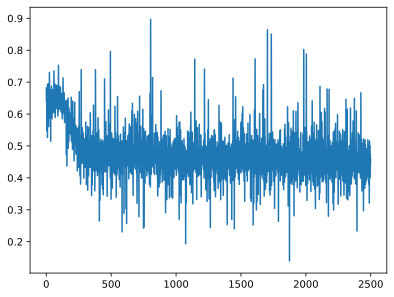

In [10]:
# 训练网络
epochs = 500
losses = []       # 记录损失函数变化的列表
    
for epoch in range(epochs):
    for (x, y) in train_loader:         # 获取小批次的x与y
        Pred = model(x)                 # 一次前向传播（小批量）
        loss = loss_fn(Pred, y)         # 计算损失函数
        losses.append(loss.item())      # 记录损失函数的变化
        optimizer.zero_grad()           # 清空梯度
        loss.backward()                 # 一次反向传播
        optimizer.step()                # 优化内部参数
        
Fig = plt.figure()
plt.plot(range(len(losses)), losses)
plt.show()

In [11]:
# 测试网络
correct = 0
total = 0

with torch.no_grad():              # 该局部关闭梯度计算功能
    for (x, y) in test_loader:     # 获取小批次的x与y
        Pred = model(x)            # 一次前向传播（小批量）
        Pred[Pred>=0.5] = 1
        Pred[Pred<0.5] = 0
        correct += torch.sum( (Pred == y).all(1) )
        total += y.size(0)
        
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 78.07017517089844 %
